# Import des modules

In [2]:
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno

import re
from bs4 import BeautifulSoup
from bs4 import NavigableString, Tag
import html as ihtml
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud


# Import de la base de données

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Import du jeu de données provenant de Stackexchange

In [3]:
# path = '/content/drive/My Drive/Colab Notebooks/Projet 6/csv'
# all_files = glob.glob(os.path.join(path, "QueryResults*.csv"))
# all_files

Concaténation et export du jeu de données (10 fichiers de 50 000 lignes et 23 colonnes)


In [4]:
# all_csv = (pd.read_csv(f, sep = ',', error_bad_lines = False, low_memory = False) for f in all_files)
# df_merged = pd.concat(all_csv, ignore_index = True)
# df_merged.to_csv('QueryResults_Merged.csv', index = False)
# !cp QueryResults_Merged.csv 'drive/My Drive/Colab Notebooks/Projet 6'

Import du jeu de données final

In [4]:
df_init = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projet 6/QueryResults_Merged.csv', sep = ',', error_bad_lines = False, low_memory = True, dtype = {'CommunityOwnedDate' : 'object'})

In [5]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projet 6/QueryResults_Merged.csv', sep = ',', error_bad_lines = False, low_memory = True, dtype = {'CommunityOwnedDate' : 'object'})

In [6]:
df.shape

(500000, 23)

# Exploration des données

## Visualisation des données manquantes

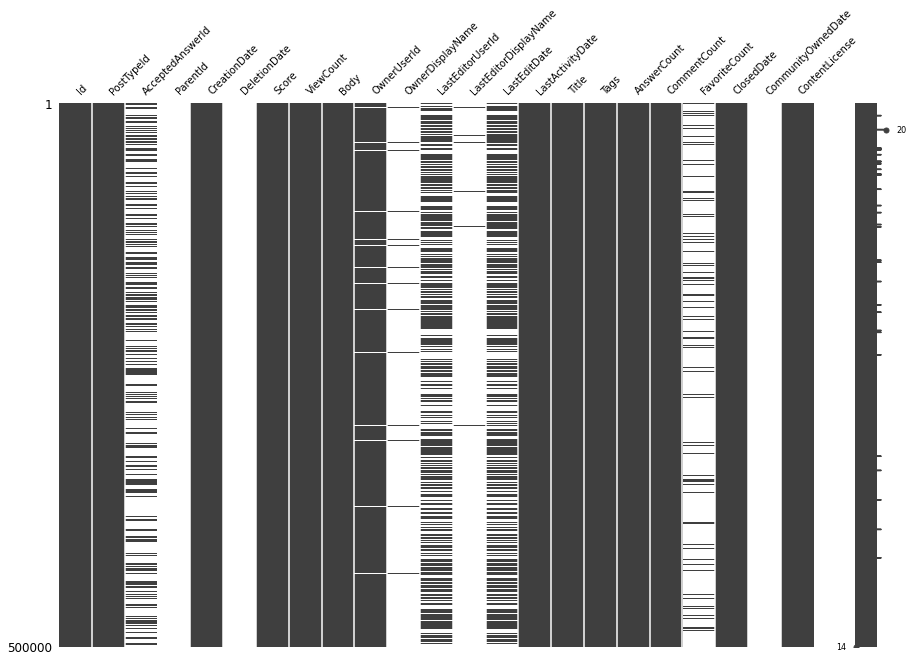

In [7]:
msno.matrix(df, figsize = (15, 10), fontsize = 10)
# plt.savefig('/content/drive/My Drive/Slides/Projet 6/msno_matrix_df.png')

## Sélection des questions ayant été consultées plus de 100 fois

In [7]:
df = df[df['ViewCount'] >= 100]
df = df.reset_index()

In [8]:
df.shape

(191156, 24)

## Nombre de tags par question avant nettoyage des tags les moins populaires

In [9]:
def nb_tags(tags):
    return len(re.findall(r'(?<=\<)[^\<\>]+(?=\>)', tags))

In [10]:
df['Nb_Tags'] = df['Tags'].apply(nb_tags)

Text(0, 0.5, '')

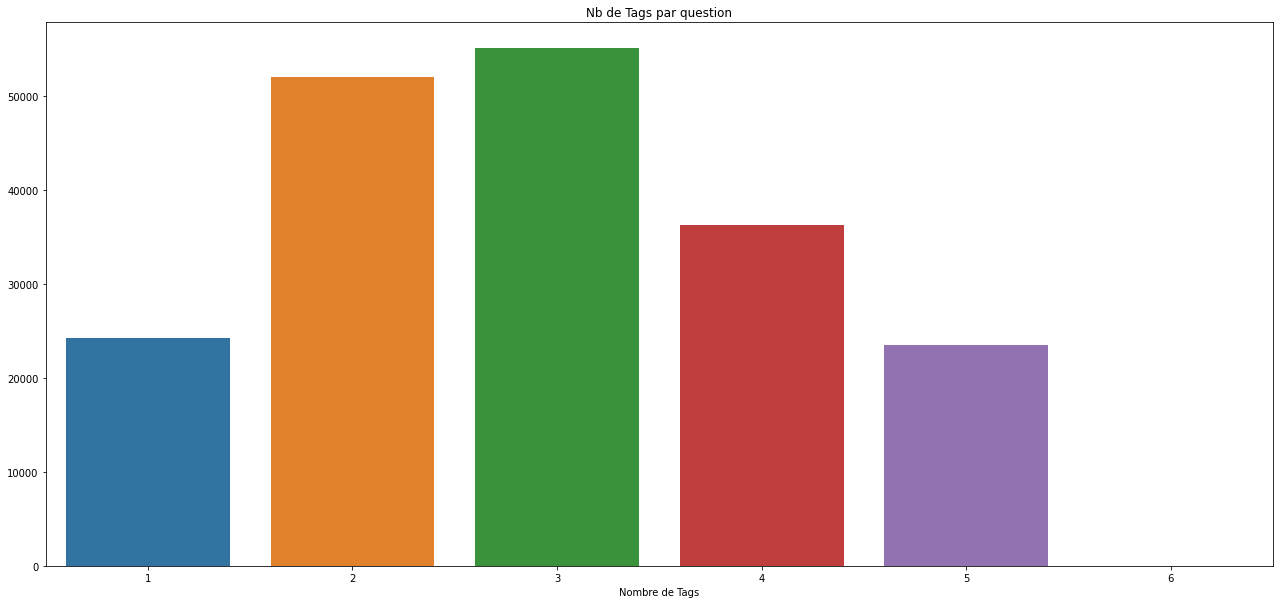

In [11]:
plt.figure(figsize = (22, 10))
sns.countplot(x = "Nb_Tags", data = df)
ax = plt.xticks(rotation = 0)
plt.title('Nb de Tags par question')
plt.xlabel('Nombre de Tags')
plt.ylabel('')

## Identification des tags uniques

In [12]:
df['Tags']

0                                            <python><date>
1                                              <sql-server>
2                          <c#><url><request><query-string>
3                                                    <java>
4         <google-chrome-extension><push-notification><n...
                                ...                        
191151                                        <java><javac>
191152                           <javascript><ecmascript-6>
191153                                          <c#><regex>
191154                        <c#><asp.net><linq><group-by>
191155                                               <java>
Name: Tags, Length: 191156, dtype: object

In [13]:
df['Tags_2'] = df['Tags']
df['Tags_2'].replace('<', '', regex = True, inplace = True)
df['Tags_2'].replace('>', '@@ù', regex = True, inplace = True)

In [14]:
#Les 50 tags les plus populaires :
vectorizer = CountVectorizer(tokenizer = lambda x: x.split('@@ù'))
tags_data = vectorizer.fit_transform(df['Tags_2'])
tag_sum = tags_data.sum(axis = 0).A1
tag_count = dict(zip(vectorizer.get_feature_names(), tag_sum))
tag_count_sorted = dict(sorted(tag_count.items(), key = lambda x: x[1], reverse = True))
tag_cols = {"Tags":list(tag_count_sorted.keys()), "Count": list(tag_count_sorted.values())}
tag_df = pd.DataFrame(data = tag_cols)
tag_df.drop([0], inplace = True)
tag_df[0:50]

,Tags,Count
1,python,27580
2,java,25259
3,javascript,22407
4,c#,16424
5,php,12259
6,html,11339
7,android,11301
8,c++,10867
9,css,8171
10,c,7125


Text(0, 0.5, 'Nombre de tags')

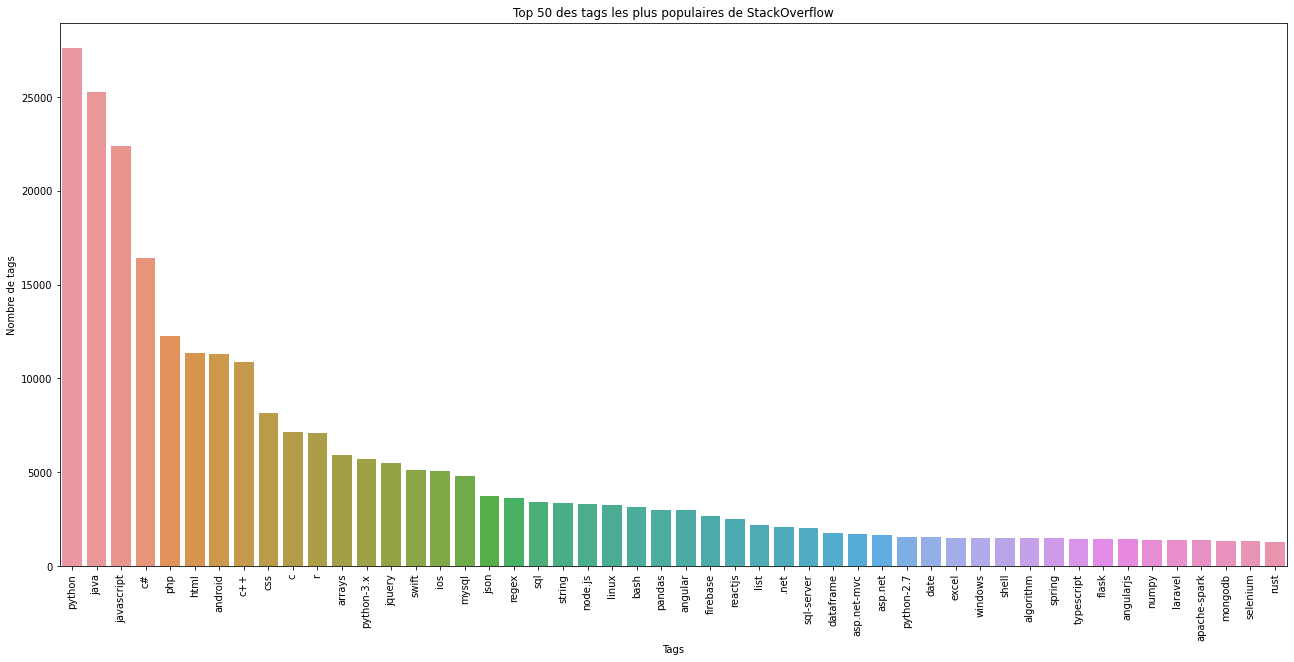

In [15]:
plt.figure(figsize = (22, 10))
sns.barplot(y = "Count", x = "Tags", data = tag_df[0:50])
ax = plt.xticks(rotation = 90)
plt.title('Top 50 des tags les plus populaires de StackOverflow')
plt.xlabel('Tags')
plt.ylabel('Nombre de tags')

Pour la suite du projet, nous allons conserver uniquement le sujets contenant 50 tags les plus populaires sur la plateforme

In [16]:
%%time
stop_tags = tag_df['Tags'].iloc[:50].to_list()
df['Tags_2'].replace('@@ù', ' ', regex = True, inplace = True)
df['Tags_2'] = df['Tags_2'].apply(lambda x: ' '.join([word for word in x.split() if word in (stop_tags)]))

CPU times: user 806 ms, sys: 2.26 ms, total: 808 ms
Wall time: 808 ms


In [17]:
df = df.loc[df['Tags_2'] != '']

In [18]:
df['Tags_2'] = df['Tags_2'].apply(lambda x: x.split())

In [19]:
df['Tags_2']

0         [python, date]
1           [sql-server]
2                   [c#]
3                 [java]
5                  [css]
               ...      
191151            [java]
191152      [javascript]
191153       [c#, regex]
191154     [c#, asp.net]
191155            [java]
Name: Tags_2, Length: 169575, dtype: object

In [20]:
df.shape

(169575, 26)

## Nombre de tags par question après nettoyage des tags les moins populaires

Text(0, 0.5, '')

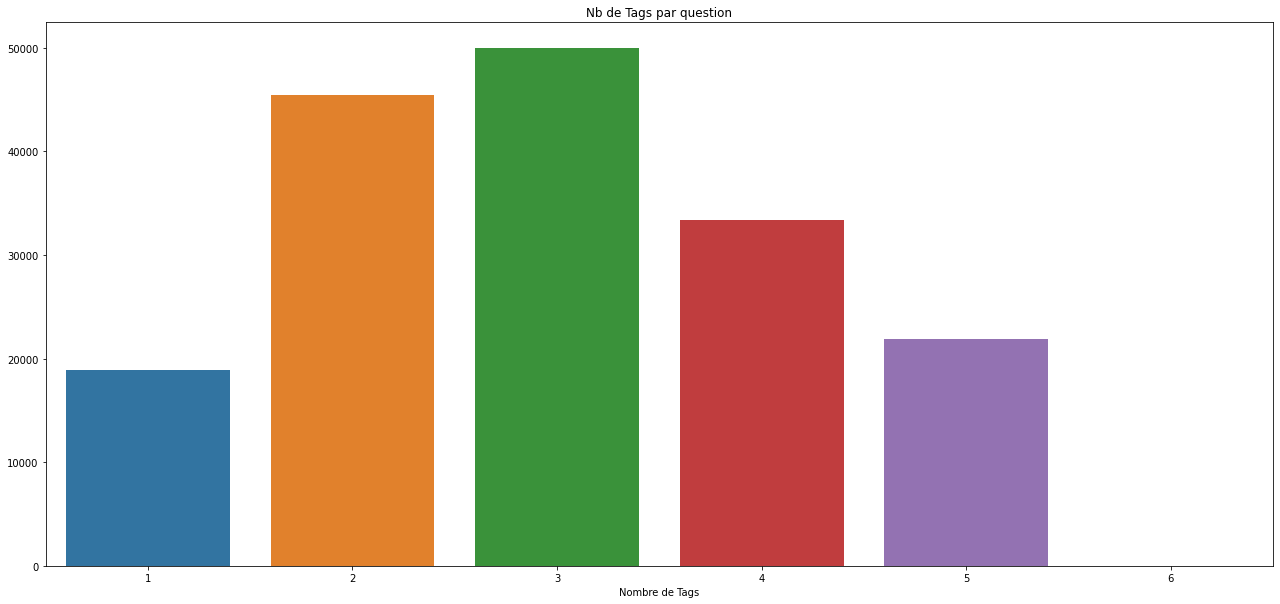

In [21]:
plt.figure(figsize = (22, 10))
sns.countplot(x = "Nb_Tags", data = df)
ax = plt.xticks(rotation = 0)
plt.title('Nb de Tags par question')
plt.xlabel('Nombre de Tags')
plt.ylabel('')

## Comparaison du nombre de questions total et >100 vues au cours du temps

Nb de questions > 100 vues

In [22]:
df_date_init = df_init[['CreationDate', 'Title']].groupby('CreationDate').agg('count')
df_date_init.reset_index(inplace = True)
df_date_init['CreationDate'] = pd.to_datetime(df_date_init['CreationDate'], errors='coerce')
df_date_init['CreationDate'] = df_date_init['CreationDate'].dt.strftime('%Y/%m')
df_date_init_2 = df_date_init.groupby(['CreationDate']).size().reset_index()

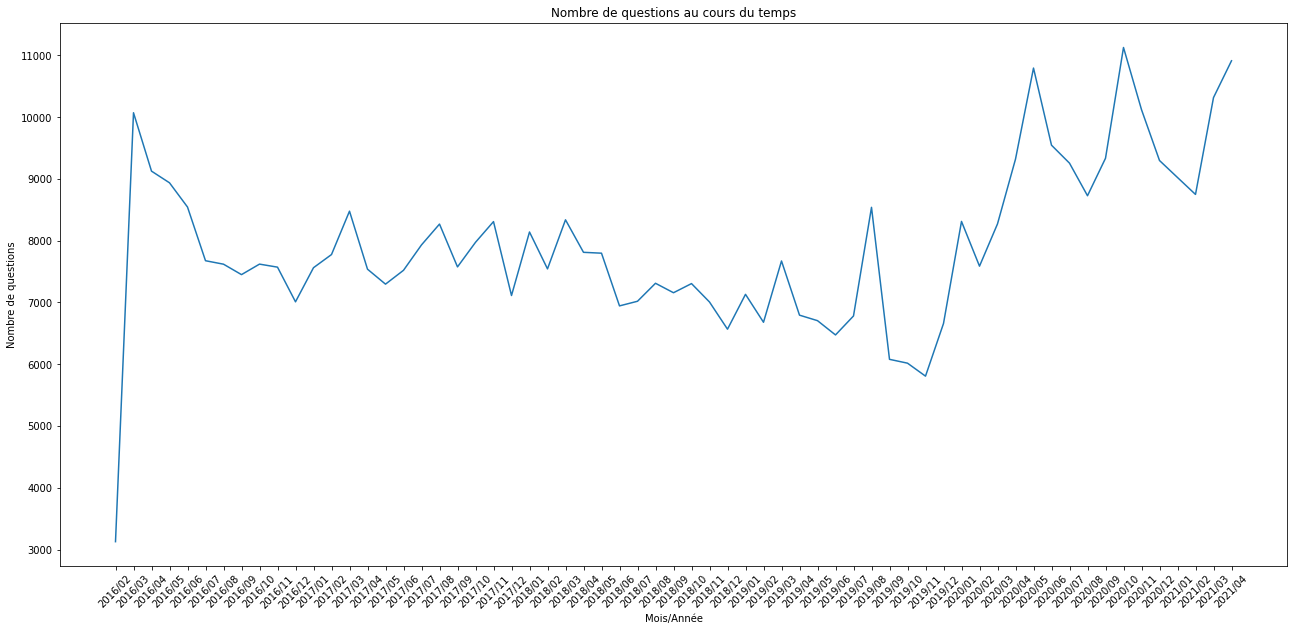

In [23]:
plt.figure(figsize = (22, 10))
sns.lineplot(data = df_date_init_2, x = 'CreationDate', y = 0)
plt.title('Nombre de questions au cours du temps')
plt.xlabel('Mois/Année')
plt.ylabel('Nombre de questions')
ax = plt.xticks(rotation = 45)

Nb de questions total

In [24]:
df_date = df[['CreationDate', 'Title']].groupby('CreationDate').agg('count')
df_date.reset_index(inplace = True)
df_date['CreationDate'] = pd.to_datetime(df_date['CreationDate'], errors='coerce')
df_date['CreationDate'] = df_date['CreationDate'].dt.strftime('%Y/%m')
df_date_2 = df_date.groupby(['CreationDate']).size().reset_index()

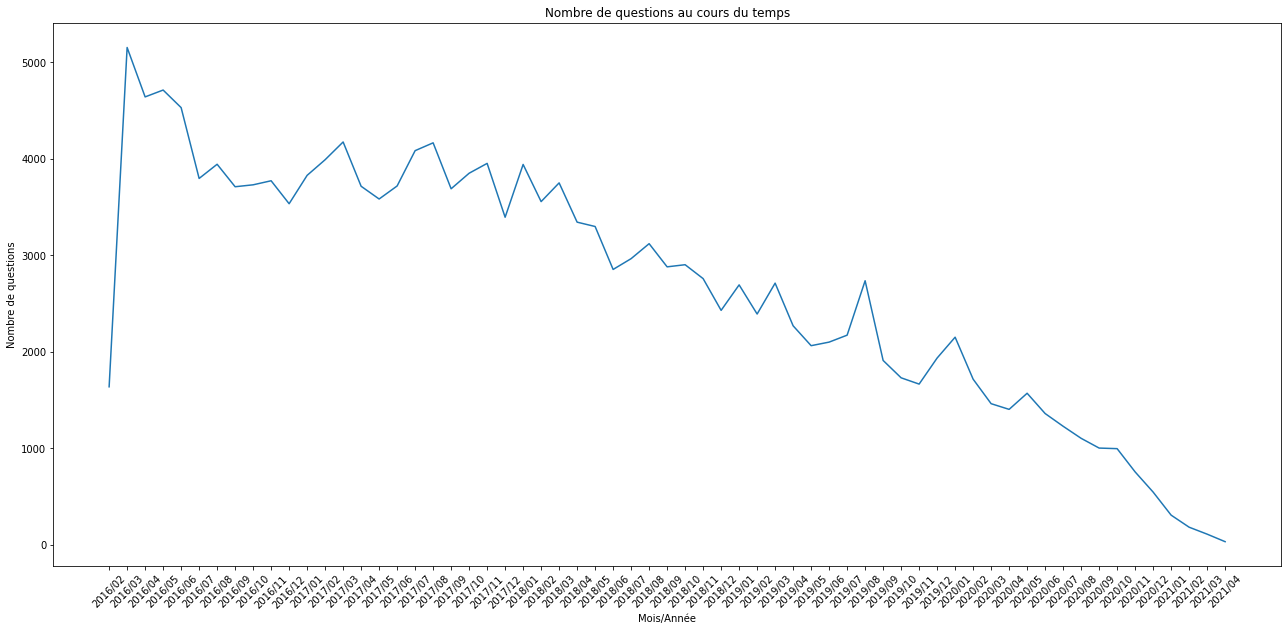

In [25]:
plt.figure(figsize = (22, 10))
sns.lineplot(data = df_date_2, x = 'CreationDate', y = 0)
plt.title('Nombre de questions au cours du temps')
plt.xlabel('Mois/Année')
plt.ylabel('Nombre de questions')
ax = plt.xticks(rotation = 45)

Représentation graphique

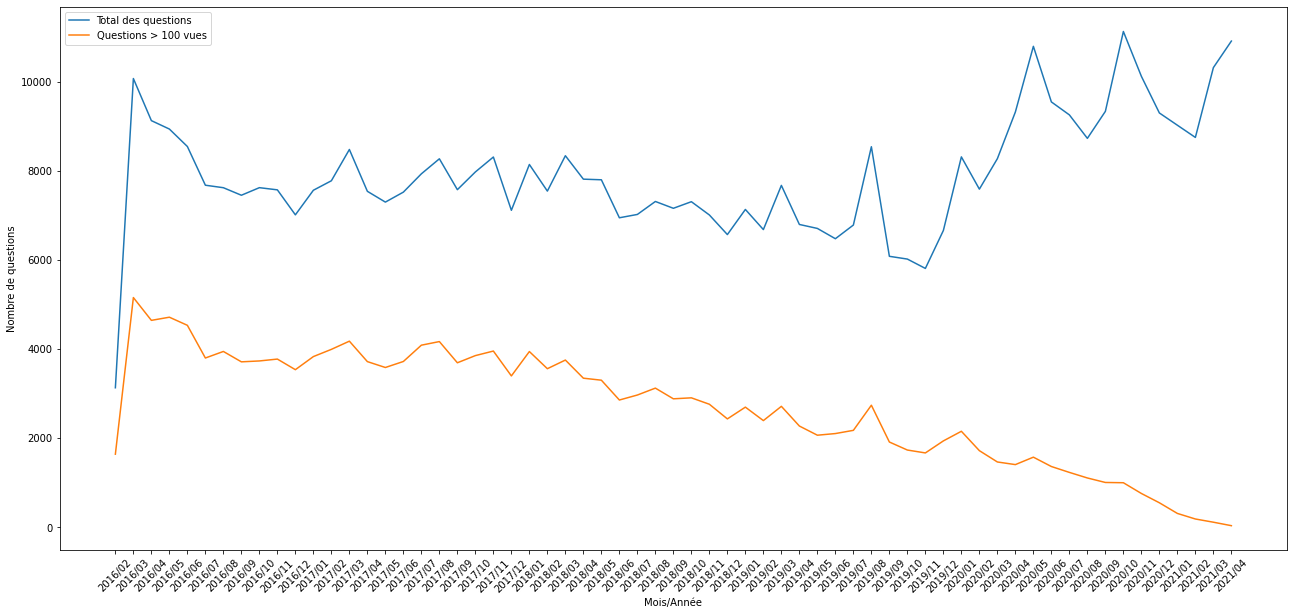

In [27]:
plt.figure(figsize = (22, 10))
sns.lineplot(data = df_date_init_2, x = 'CreationDate', y = 0, label = 'Total des questions')
sns.lineplot(data = df_date_2, x = 'CreationDate', y = 0, label = 'Questions > 100 vues')
plt.xlabel('Mois/Année')
plt.ylabel('Nombre de questions')
ax = plt.xticks(rotation = 45)

# Preprocessing des variables 'Body' et 'Title'

## Fonctions

In [ ]:
# #Installation des stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def cleanHtml(html) :
    soup = BeautifulSoup(html, "html.parser")
    for tag in soup.findAll('code'):
        tag.clear()
    for script in soup(["script", "style"]) :
        script.extract()
    text = soup.get_text()
    lines = (line.strip() for line in text.splitlines())
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    cleantext = '\n'.join(chunk for chunk in chunks if chunk)
    return cleantext


def cleanPunc(sentence) :
    cleaned = re.sub(r'[?|!|\'|"|#|@]', r'',sentence)
    cleaned = re.sub(r'[.|,|;|:|}|{|)|(|\|/]', r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

def keepAlpha(sentence) :
    alpha_sentence = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sentence += alpha_word
        alpha_sentence += " "
    alpha_sentence = alpha_sentence.strip()
    return alpha_sentence


def cleanStopwords(sentence) :
  text_tokens = word_tokenize(sentence)
  stop_words = nltk.corpus.stopwords.words('english')
  text = ' '.join([word for word in text_tokens if not word in stop_words])
  return text


def lemmatization(sentence) :
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in sentence.split()]
    return text

def cleanDigit(sentence) :
  exception = ['a', 'b', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
  text = ' '.join([w for w in sentence.split() if (w not in exception)])
  return text

def cleanPos(sentence) :
  verb_adverb_pronoun = ['PRP','PRP$', 'RB', 'RBR', 'RBS', 'TO', 'VB', 'VBG', 'VBD', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']
  tagged_sentence = nltk.tag.pos_tag(sentence.split())
  edited_sentence = ' '.join([word for word, tag in tagged_sentence if (tag not in verb_adverb_pronoun)])
  return edited_sentence

## Variable Title

In [ ]:
%%time
df['Title_2'] = df['Title'].str.lower()
df['Title_2'] = df['Title_2'].apply(cleanHtml)
df['Title_2'] = df['Title_2'].apply(cleanPos)
df['Title_2'] = df['Title_2'].apply(cleanPunc)
df['Title_2'] = df['Title_2'].apply(keepAlpha)
df['Title_2'] = df['Title_2'].apply(cleanStopwords)
df['Title_2'] = df['Title_2'].apply(lemmatization)
df['Title_2'] = df['Title_2'].apply(lambda x: ' '.join(map(str, x)))
df['Title_2'] = df['Title_2'].apply(cleanDigit)

CPU times: user 2min 44s, sys: 6.85 s, total: 2min 51s
Wall time: 2min 50s


In [ ]:
df[['Title','Title_2']].head()

,Title,Title_2
0,Convert YYYY-MM-DD HH:MM:SS to YYYY-MM-DD python,convert yyyy mm dd hh mm yyyy mm dd python
1,access sql query logs from audit file,access sql query log audit file
2,How To Request multiple QueryStrings out of one URL?,multiple querystrings one url
3,how to read body of a post packet in java,body post packet java
5,Unknown offset. (inline-flex element + clearfix),unknown offset inline flex element clearfix


## Variable Body

In [ ]:
%%time
df['Body_2'] = df['Body'].str.lower()
df['Body_2'] = df['Body_2'].apply(cleanHtml)
df['Body_2'] = df['Body_2'].apply(cleanPunc)
df['Body_2'] = df['Body_2'].apply(keepAlpha)
df['Body_2'] = df['Body_2'].apply(cleanPos)
df['Body_2'] = df['Body_2'].apply(cleanStopwords)
df['Body_2'] = df['Body_2'].apply(lemmatization)
df['Body_2'] = df['Body_2'].apply(lambda x: ' '.join(map(str, x)))
df['Body_2'] = df['Body_2'].apply(cleanDigit)

CPU times: user 15min 5s, sys: 10.6 s, total: 15min 16s
Wall time: 15min 14s


In [ ]:
df[['Body','Body_2']].head()

,Body,Body_2
0,"<p>I'm trying to convert </p>\n\n<pre><code>YYYY-MM-DD HH_MM_SS\n</code></pre>\n\n<p>to </p>\n\n<pre><code>YYYY-MM-DD \n</code></pre>\n\n<p>example:</p>\n\n<pre><code>from datetime import datetime, timedelta\nfrom dateutil.relativedelta import relativedelta\ni=0\nvar=""2016-05-03""\nwhile i &lt; 5\nnew_date = datetime.strptime(var, ""%Y-%m-%d"") + relativedelta(days=i)\ni=i+1\nprint(new_date)\n</code></pre>\n\n<p>in this example I would like to convert new_date to string YYYY-MM-DD. I have tried...",im example example would new date yyyy mm dd many option none easy
1,"<p>In standart edition there is a file which has some info about sql queries logs . and i can access these info with running this query</p>\n\n<pre><code>SELECT * FROM fn_get_audit_file('C:\Audit\PCI_Audit*', default, default) \n</code></pre>\n\n<p>this is file name</p>\n\n<pre><code>PCI_Audit_EC556E8F-04F0-4E7F-B29E-4856C72ECAEE_0_131108208217630000.sqlaudit\n</code></pre>\n\n<p>and you can download it from <a href=""https://mega.nz/#!l0Rj1AZb!m60XR3FmzNfXCuI5ESPadpJ7-hnp5g4Mm_5jqicdFwQ"" rel...",standart edition file info sql query log access info query file name could file access suggestion much thank
2,"<p>My URL is built like this: localhost:56698/Default.aspx?<code>lehrlingID=114</code>\nThe <code>lehrlingID=114</code> that you see at the end of my url gets saved in a variable like this </p>\n\n<pre><code>lehrlingID = Convert.ToInt32(Request.QueryString[""lehrlingID""]);` \n</code></pre>\n\n<p>Now i have to check for another variable as well like this: </p>\n\n<pre><code>string md5key = Request.QueryString[""id""];\n</code></pre>\n\n<p>My URL should look like this then: localhost:56698/Defaul...",url like localhost default end url variable like another variable like url like default aspxlehrlingid different variable url questionmark variable url
3,"<p>Basically I have created a java server which reads incoming packets, but the problem is when a post packet comes it doesn't read the body portion that contains the actual data, it shows the message as <code>POST /index.html http/1.1</code>.</p>\n\n<p>Here is how i read the data on my server:</p>\n\n<pre><code>try{\n IR = new InputStreamReader(socket.getInputStream());\n}catch(Exception ie){\n System.out.println(""Cound'nt create IR"");\n}\n\nBufferedReader BR = new BufferedReader(IR);...",java server packet problem post packet doesnt body portion actual data message data server could body received packet
5,"<p>Unknown offset. In latest Chrome, FF, IE </p>\n\n<p>Explain please, what the <strong>top</strong> offset (1em) ?</p>\n\n<p><a href=""https://i.stack.imgur.com/O3bad.png"" rel=""nofollow noreferrer""><img src=""https://i.stack.imgur.com/O3bad.png"" alt=""enter image description here""></a></p>\n\n<p><a href=""https://jsfiddle.net/5q08Lqnf/3/"" rel=""nofollow noreferrer"" title=""JSFiddle"">JSFiddle</a></p>\n\n<p><div class=""snippet"" data-lang=""js"" data-hide=""false"" data-console=""true"" data-babel=""false""...",unknown offset latest chrome ff ie top offset em jsfiddle similar question inline flex element clearfix weird white space


# Enregistrement du nouveau Dataset après nettoyage

Elimination des lignes étant vide après preprocessing (ex : texte Russe)

In [ ]:
df[df['Body_2'] == '']

,index,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense,Nb_Tags,Tags_2,Title_2,Body_2
341,626,38823583,1,38823639.0,NaN,2016-08-08 07:33:49,NaN,-6,110,"<pre><code>function photos(){\n\n FB.api( ""/{839506469483059}/photos"", function (response) { if (response &amp;&amp; !response.error) {\n var photos_name = document.getElementById(""statusq"").innerHTML = response.picture;\n }\n }\n);\n}\n</code></pre>\n",6531498.0,NaN,1945960.0,NaN,2016-08-08 07:35:07,2016-08-08 09:20:09,"How we get user facebook album pictures, This api is not working",<php><facebook-javascript-sdk>,2,1,NaN,2016-09-02 02:37:55,NaN,CC BY-SA 3.0,2,[php],user facebook album picture api,
1379,2399,38691031,1,38691086.0,NaN,2016-08-01 04:26:57,NaN,0,551,"<pre><code>var index = 30\n\nswitch index {\n\n case 10 : \n println( ""Value of index is 10"")\n case 20 :\n\n case 30 : \n println( ""Value of index is either 20 or 30"")\n case 40 : \n println( ""Value of index is 40"")\n default : \n println( ""default case"")\n}\n</code></pre>\n",5478666.0,NaN,4253437.0,NaN,2018-07-05 14:24:15,2018-07-05 14:24:15,Why fallthrough concept of switch case not allowed in swift?,<ios><swift><switch-statement>,2,1,0.0,2016-08-01 04:41:32,NaN,CC BY-SA 3.0,3,"[ios, swift]",fallthrough concept switch case swift,
1556,2704,38670796,1,38672234.0,NaN,2016-07-30 05:52:04,NaN,-1,940,<pre><code>&gt;&gt;&gt; test = lambda f: f(lambda x: x + 1)(0)\n&gt;&gt;&gt; z = lambda f: lambda x: x\n&gt;&gt;&gt; test(z)\n0\n\n&gt;&gt;&gt; succ = lambda n: lambda f: lambda x: f(n(f)(x))\n&gt;&gt;&gt; _1 = succ(z)\n&gt;&gt;&gt; test(_1)\n1\n\n&gt;&gt;&gt; _2 = succ(_1)\n&gt;&gt;&gt; test(_2)\n2\n\n&gt;&gt;&gt; plus = lambda m: lambda n: lambda f: lambda x: m(f)(n(f)(x))\n&gt;&gt;&gt; _3 = plus(_1)(_2)\n&gt;&gt;&gt; test(_3)\n3\n\n&gt;&gt;&gt; mult = lambda m: lambda n: lambda f: lambda ...,6633402.0,NaN,5422525.0,NaN,2016-07-30 07:03:21,2016-07-30 09:08:21,Python nested lambda expression still confused and couldn't understandable. please explain the following example,<python><lambda>,1,3,NaN,2016-07-31 02:19:11,NaN,CC BY-SA 3.0,2,[python],python lambda expression couldnt understandable please following example,
1912,3363,38622667,1,38622683.0,NaN,2016-07-27 20:32:37,NaN,3,261,"<pre><code>p = re.compile(""[AG].{2}[ATG|ATA|AAG].{1}G"")\nregex_result = p.search('ZZZAXXATGXGZZZ')\nregex_result.group()\n'AXXATG'\n</code></pre>\n\n<p>I was expecting <code>AXXATGXG</code> instead.</p>\n",2228353.0,NaN,NaN,NaN,NaN,2016-07-27 20:34:02,"Python Regex stops after first ""|"" match",<python><regex>,1,0,NaN,2016-07-31 18:56:36,NaN,CC BY-SA 3.0,2,"[python, regex]",python regex stop first match,
2084,3667,38600464,1,NaN,NaN,2016-07-26 21:50:51,NaN,-6,4672,"<pre><code>if(isset($_POST['btn_shoes']))\n{\n if(isset($_FILES['img_shoes']))\n {\n $errors= array();\n $file_name = $_FILES['img_shoes']['name'];\n $file_size =$_FILES['img_shoes']['size'];\n $file_tmp =$_FILES['img_shoes']['tmp_name'];\n $file_type=$_FILES['img_shoes']['type'];\n $file_ext=strtolower(end(explode('.',$_FILES['img_shoes']['name']))); //line 35\n</code></pre>\n",6641890.0,NaN,4577762.0,NaN,2016-07-26 23:00:18,2016-07-26 23:18:37,Notice: Only variables should be passed by reference in C:\xampp\htdocs\my\admin.php on line 35,<php>,1,3,0.0,2016-07-27 02:50:27,NaN,CC BY-SA 3.0,1,[php],variable reference c xampp htdocs admin php line,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186086,488306,53620276,1,NaN,NaN,2018-12-04 19:39:08,NaN,-1,128,"<pre><code>#Exercise 7: Counting...1...2...3...\n#The purpose of this program is to ask a file from the user, open the file \n# and counts the number of comma-separated values in it and report the result to the user\n\nnam

In [ ]:
df[df['Title_2'] == '']

,index,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense,Nb_Tags,Tags_2,Title_2,Body_2
1848,3256,38631358,1,38631453.0,NaN,2016-07-28 08:47:21,NaN,1,598,<p>I am working with this command: <code>sudo -u git -H bundle exec rake gitlab:backup:create RAILS_ENV=production</code>\nand I am the root user so I should be able to also use the command without sudo but Linux says to me after I used the command without sudo that -H is a unknown option. </p>\n,6639874.0,NaN,NaN,NaN,NaN,2016-07-28 08:51:43,What does git -H do?,<linux><git>,1,1,1.0,2016-07-28 16:23:15,NaN,CC BY-SA 3.0,2,[linux],,command root user able command without sudo linux command without sudo unknown option
3513,6275,38407962,1,NaN,NaN,2016-07-16 05:08:19,NaN,16,32129,<p>When we have to use <code>&lt;script&gt;</code> tag in <code>&lt;head&gt;</code> section and when we have to use the <code>&lt;script&gt;</code> tag in body section? What is the difference between these two occurrences?</p>\n,5435549.0,NaN,NaN,user663031,2016-07-16 05:26:38,2016-07-16 05:35:06,When to use the <script> tag in the head and body section of a html page?,<javascript><html>,2,3,6.0,2016-07-16 05:27:27,NaN,CC BY-SA 3.0,2,"[javascript, html]",,tag section tag body section difference two occurrence
3645,6507,38391185,1,NaN,NaN,2016-07-15 08:16:28,NaN,0,1147,"<p>I am reading about the difference between PermGen and Metaspace and one of the disadvantages of the former is that there is a fixed size at startup. I do not understand why is it fixed if you have two parameters to tune it:</p>\n\n<pre><code>-XX:PermSize\n-XX:MaxPermSize\n</code></pre>\n\n<p>It seems to me that we can say the same about Metaspace, it is also fixed at startup by MaxMetspaceSize (I know that by default it is unlimited but it seems not a good practice to leave it as such).</...",3763116.0,NaN,NaN,NaN,NaN,2016-07-15 08:16:28,MaxPermSize vs MaxMetaspaceSize,<java><garbage-collection><java-8><metaspace>,0,2,NaN,2016-07-15 19:11:37,NaN,CC BY-SA 3.0,4,[java],,difference permgen metaspace one disadvantage former fixed size startup fixed two parameter metaspace startup maxmetspacesize default unlimited good practice something difference maxpermsize
3693,6574,38384938,1,NaN,NaN,2016-07-14 21:59:50,NaN,0,111,"<p><a href=""https://i.stack.imgur.com/tj11A.png"" rel=""nofollow noreferrer""><img src=""https://i.stack.imgur.com/tj11A.png"" alt=""enter image description here""></a></p>\n\n<p>I have a structure like this. A container with 5 cards (5 elements, each with a header, content and footer). Header, footer and content have static heights but the card itself has dynamic one (because content can dynamically grow). Im trying to add animations using css3 and I need to get the height of the cards when conten...",5704156.0,NaN,NaN,NaN,NaN,2016-07-14 22:02:49,"Why does ""$(element).height()"" show 0?",<javascript><jquery><css>,1,3,NaN,2016-07-15 03:54:24,NaN,CC BY-SA 3.0,3,"[javascript, jquery, css]",,structure like container card element header content footer header footer content static height card dynamic one content im animation cs height card content part code content card height console chrome
3899,6943,38357378,1,38357953.0,NaN,2016-07-13 16:43:19,NaN,-6,3169,"<p>I have this string</p>\n\n<pre><code>""{id={date=1467991309000, time=1467991309000, timestamp=1467991309, timeSecond=1467991309, inc=-360249353, machine=-705844029, new=false}, id_lista={date=1467991309000, time=1467991309000, timestamp=1467991309, timeSecond=1467991309, inc=-360249354, machine=-705844029, new=false}, id_documento=1297183, estado=1, fecha_ing=1467991309026, fecha_mod=1468010645484, identificador_r=null, titulo=null, pais=null, sector=null, url=null, dato1=null, dato2=null}...",5077857.0,NaN,5077857.0,NaN,2016-07-14 15:29:32,2016-07

In [ ]:
df2 = df.copy()
df2['Body_2'] = df2['Body_2'].replace('', np.nan)
df2['Title_2'] = df2['Title_2'].replace('', np.nan)
df2['Title_2'] = df2['Title_2'].replace('null', np.nan)
df2 = df2.dropna(subset = ['Body_2', 'Title_2'])
df2 = df2[['Id', 'Body_2', 'Title_2', 'Tags_2']]

In [ ]:
df2.shape

(168931, 4)

In [ ]:
df2.to_csv('df_clean.csv', sep = ',', index = False)
!cp df_clean.csv "/content/drive/My Drive/Colab Notebooks/Projet 6/"

# WordCloud

## Title

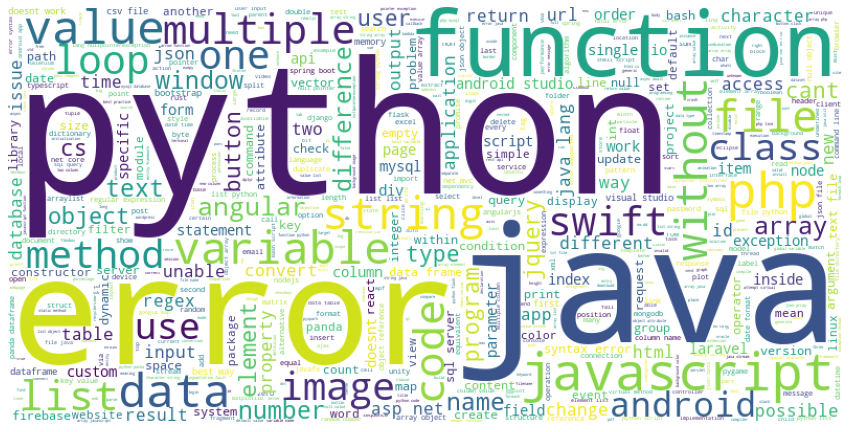

In [ ]:
plt.figure(figsize = (15,10))
long_string = ' '.join(list(df['Title_2'].values))
wordcloud = WordCloud(background_color = "white", max_words = 5000, contour_width = 3, width= 800, height = 400, contour_color = 'steelblue')
wordcloud.generate(long_string)
plt.axis("off")
plt.imshow(wordcloud)

## Tags


In [35]:
df['Tags_3'] = df['Tags']
df['Tags_3'].replace('<', '', regex = True, inplace = True)
df['Tags_3'].replace('>', '@@ù', regex = True, inplace = True)
vectorizer = CountVectorizer(tokenizer = lambda x: x.split('@@ù'))
tags_data = vectorizer.fit_transform(df['Tags_3'])
tag_sum = tags_data.sum(axis = 0).A1
tag_count = dict(zip(vectorizer.get_feature_names(), tag_sum))
tag_count_sorted = dict(sorted(tag_count.items(), key = lambda x: x[1], reverse = True))
tag_cols = {"Tags":list(tag_count_sorted.keys()), "Count": list(tag_count_sorted.values())}
tag_df = pd.DataFrame(data = tag_cols)
tag_df.drop([0], inplace = True)
tag_df = pd.Series(tag_df.Count.values, index = tag_df.Tags).to_dict()

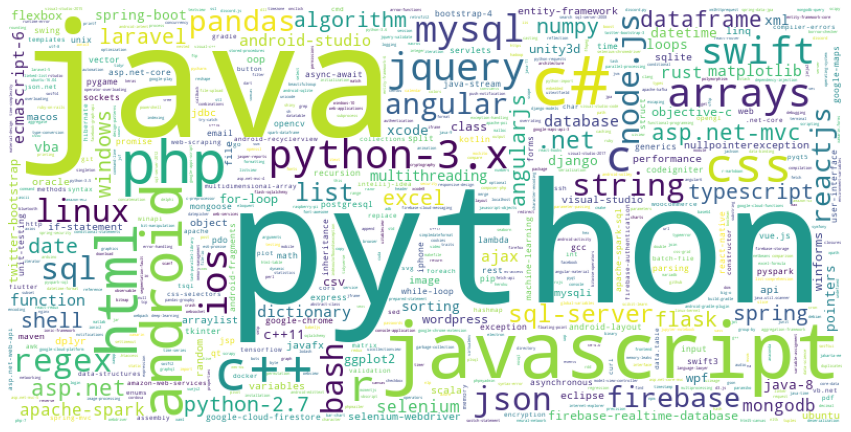

In [ ]:
plt.figure(figsize = (15,10))
wordcloud = WordCloud(background_color = "white", max_words = 5000, contour_width = 3, width= 800, height = 400, contour_color = 'steelblue').generate_from_frequencies(tag_df)
plt.axis("off")
plt.imshow(wordcloud)